In [1]:
%load_ext autoreload
%autoreload 2

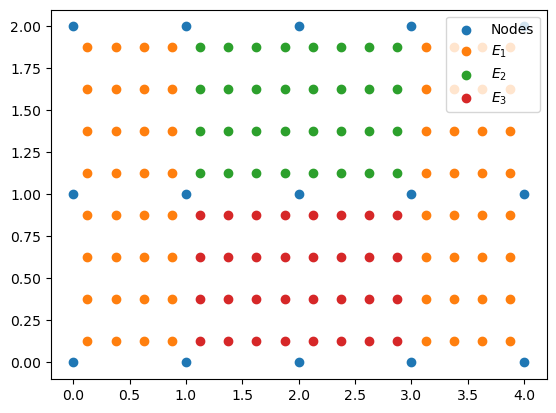

In [2]:
import jax.numpy as jnp
import json
import matplotlib.pyplot as plt
with open("particles.json", "r") as f:
    ploc = jnp.asarray(json.load(f))

nx, ny = jnp.meshgrid(jnp.arange(5), jnp.arange(3))
p1 = jnp.concatenate((ploc[:16], ploc[48:80], ploc[-16:]))
p2 = ploc[80:112]
p3 = jnp.concatenate((ploc[16:32], ploc[32:48]))

plt.scatter(nx, ny, label='Nodes')
plt.scatter(p1[:,0,0], p1[:,0,1], label='$E_1$')
plt.scatter(p2[:,0,0], p2[:,0,1], label='$E_2$')
plt.scatter(p3[:,0,0], p3[:,0,1], label='$E_3$')
plt.legend()
plt.show()

In [5]:
jax.clear_caches()

In [5]:
cnfs


[]

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
import jax
import jaxopt
from jax import grad, jit, value_and_grad
from jax.scipy.optimize import minimize
from tqdm import tqdm
import json
from scipy import signal
from functools import partial
import einops
import copy

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import HTML
from IPython.display import display


import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from diffmpm.constraint import Constraint
from diffmpm.element import Quad4N, Quad4NState
from diffmpm.explicit import ExplicitSolver
from diffmpm.forces import NodalForce
from diffmpm.functions import Unit, Linear
from diffmpm.io import Config
from diffmpm.materials import init_simple, init_linear_elastic
from diffmpm.particle import _ParticlesState, init_particle_state
@jit
def rolling_gaussian_generator(velocity, frequency, node_x_locs, N=5):
    time_to_center = node_x_locs / velocity

    fc = frequency
    t_width = N / fc  # half-width of time range

    t = jnp.linspace(-t_width, t_width, 2 * 100, endpoint=False)
    i, q, e = gausspulse(t, fc=fc)

    t_pad = jnp.array([-t_width - 1e-16, t_width + 1e-16])
    e_pad = jnp.array([0, 0])

    t = jnp.concatenate([t_pad[:1], t, t_pad[1:]])
    e = jnp.concatenate([e_pad[:1], e, e_pad[1:]])

    xvalues = t + time_to_center[:, jnp.newaxis]
    fxvalues = e
    return xvalues, fxvalues

@jit
def gausspulse(t, fc=1000, bw=0.5, bwr=-6):
    """
    Return a Gaussian modulated sinusoid:

        ``exp(-a t^2) exp(1j*2*pi*fc*t).``

    Parameters
    ----------
    t : ndarray
        Input array.
    fc : float, optional
        Center frequency (e.g. Hz).  Default is 1000.
    bw : float, optional
        Fractional bandwidth in frequency domain of pulse (e.g. Hz).
        Default is 0.5.
    bwr : float, optional
        Reference level at which fractional bandwidth is calculated (dB).
        Default is -6.

    Returns
    -------
    yI : ndarray
        Real part of signal.
    yQ : ndarray
        Imaginary part of signal.
    yenv : ndarray
        Envelope of signal.
    """

    # Convert t to a jnp array if it's not already
    t = jnp.asarray(t)

    # exp(-a t^2) <->  sqrt(pi/a) exp(-pi^2/a * f^2)  = g(f)
    ref = jnp.power(10.0, bwr / 20.0)
    
    # pi^2/a * fc^2 * bw^2 /4=-log(ref)
    a = -(jnp.pi * fc * bw) ** 2 / (4.0 * jnp.log(ref))

    yenv = jnp.exp(-a * t * t)
    yI = yenv * jnp.cos(2 * jnp.pi * fc * t)
    yQ = yenv * jnp.sin(2 * jnp.pi * fc * t)

    return yI, yQ, yenv



def calc_objective(strain):

    strain_x = strain[:, :, 0]
    regrouped = einops.rearrange(strain_x, 'time (x y e1 e2) -> time (x e1) (y e2)', x=2, y=4, e1=4, e2=4)[:, 0, :][:, 4:12]
    avg = jnp.array([(regrouped[:,i] + regrouped[:,i + 1]) / 2 for i in range(regrouped.shape[1] - 1)])
    out = einops.rearrange(avg, 'avg time -> time avg')
    # regrouped = einops.rearrange(strain_x, 'time (x y e1 e2) -> time (x e1) (y e2)', x=2, y=4, e1=4, e2=4)[:, :, :]
    # avg = jnp.array([(regrouped[:,:,i] + regrouped[:,:,i + 1]) / 2 for i in range(regrouped.shape[2] - 1)])
    # out = einops.rearrange(avg, 'avg time y -> time avg y')
    
    return out

# material
E_true = [1100, 900, 800]
materials = [init_linear_elastic(
    {
        "youngs_modulus": E_true[i], 
        "poisson_ratio" : 0, 
        "density": 1, 
        "id" : i
    }
    ) for i in range(len(E_true))]

# particles
with open("particles.json", "r") as f:
    ploc = jnp.asarray(json.load(f))

particles = []
for i in range(8):
    if i in [1, 2]:
        material = materials[2]
    elif i in [5, 6]:
        material = materials[1]
    else:
        material = materials[0]
    particles.append(init_particle_state(
        ploc[16*i:16*(i+1)], 
        material, 
        jnp.zeros(ploc[16*i:16*(i+1)].shape[0], dtype=jnp.int32)
    ))
    
# external forces
velocity = 4
frequency = 5
node_x_locs = jnp.arange(5)
xvalues, fxvalues = rolling_gaussian_generator(velocity, frequency, node_x_locs)

cnfs = []
true_f = -10
for i in range(5):
    fn = Linear(-1, xvalues[i], fxvalues * true_f)
    # fn = Unit(-1)
    cnfs.append(NodalForce(node_ids=[10 + i], function=fn, dir=1, force=1))
pst = []

# element
elementor = Quad4N(total_elements=8)
constraints = [
    (jnp.array([0,4,10,14]), Constraint(0, 0.0)), 
    (jnp.array([0,4,10,14]), Constraint(1, 0.0))
]
elements = elementor.init_state(
    [4,2], 
    8, 
    [1,1], 
    constraints, 
    concentrated_nodal_forces=cnfs
)
fresh_elements = copy.deepcopy(elements)


solver = ExplicitSolver(
    el_type=elementor,
    tol=1e-12,
    scheme='usf',
    dt=0.01,
    velocity_update=False,
    sim_steps=10,
    out_steps=1,
    out_dir='./results/',
    gravity=0,
)

init_vals = solver.init_state(
    {
        "elements" : elements,
        "particles" : particles,
        "particle_surface_traction" : pst,
    }
)



do_jit = True
if do_jit:
    jitted_update = jax.jit(solver.update)
    t_steps = 100
else:
    jitted_update = solver.update
    t_steps = 2

 

jit_updated = init_vals
result_locs = []
result_strain = []
for step in tqdm(range(t_steps)):
    jit_updated = jitted_update(jit_updated, step + 1)
    result_locs.append(jnp.vstack([particle.loc for particle in jit_updated.particles]))
    result_strain.append(jnp.vstack([particle.strain for particle in jit_updated.particles]))

target_locs = jnp.array(result_locs).squeeze()
target_strain = jnp.array(result_strain).squeeze()
target_rel_strain = calc_objective(target_strain)

jnp.save("target_rel_strain.npy", target_rel_strain)

# @jit
def compute_loss(params, *, solver, target, iter):
    materials = [
            init_linear_elastic(
            {
                "youngs_modulus": params[i],
                "density": 1,
                "poisson_ratio": 0,
                "id": i,
            }
        )
        for i in range(len(params[:3]))]
    
    particles_ = []
    for i in range(8):
        if i in [1, 2]:
            material = materials[2]
        elif i in [5, 6]:
            material = materials[1]
        else:
            material = materials[0]
        particles_.append(init_particle_state(
            ploc[16*i:16*(i+1)], 
            material, 
            jnp.zeros(ploc[16*i:16*(i+1)].shape[0], dtype=jnp.int32)
        ))

    # external forces
    velocity = params[3]
    frequency = params[4]
    node_x_locs = jnp.arange(5)
    xvalues, fxvalues = rolling_gaussian_generator(velocity, frequency, node_x_locs)

    cnfs = []
    for i in range(5):
        fn = Linear(iter, xvalues[i], fxvalues * params[5])
        # fn = Unit(-1)
        cnfs.append(NodalForce(node_ids=[10 + i], function=fn, dir=1, force=1))

    # element
    elementor_ = Quad4N(total_elements=8)
    constraints = [
        (jnp.array([0,4,10,14]), Constraint(0, 0.0)), 
        (jnp.array([0,4,10,14]), Constraint(1, 0.0))
    ]
    # elements_ = copy.deepcopy(fresh_elements)
    elements_ = elementor_.init_state(
        [4,2], 
        8, 
        [1,1], 
        constraints, 
        concentrated_nodal_forces=cnfs
    )


    init_vals = solver.init_state(
        {
            "elements": elements_,
            "particles": particles_,
            "particle_surface_traction": [],
        }
    )
    result = init_vals
    result_strain = []
    for step in tqdm(range(t_steps), leave=False):
        result = jitted_update(result, step + 1)        
        result_strain.append(jnp.vstack([particle.strain for particle in result.particles]))

    result_strain = jnp.array(result_strain).squeeze()
    rel_strain = calc_objective(result_strain)
    loss = jnp.linalg.norm(target - rel_strain)
    return loss


def optax_adam(params, niter, mpm, target):
    # Initialize parameters of the model + optimizer.
    start_learning_rate = 1e-0
    optimizer = optax.amsgrad(start_learning_rate)
    opt_state = optimizer.init(params)

    param_list = []
    loss_list = []
    # A simple update loop.
    t = tqdm(range(niter), desc=f"Params: {params}")
    
    for iter in t:
        partial_f = partial(compute_loss, solver=mpm, target=target, iter=iter)
        lo, grads = jax.value_and_grad(partial_f, argnums=0)(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        t.set_description(f"Params: {params}")
        param_list.append(params)
        loss_list.append(lo)
        # save updated params + losses for when the process is killed
        jnp.save("params.npy", jnp.array(param_list))
        jnp.save("losses.npy", jnp.array(loss_list))
    return param_list, loss_list


params = jnp.array([1000.0, 1000.0, 1000.0, 4.0, 5.0, -10.0])

material = [
        init_linear_elastic(
        {
            "youngs_modulus": params[i],
            "density": 1,
            "poisson_ratio": 0,
            "id": i,
        }
    )
    for i in range(len(params[:3]))]
    
particles = []
for i in range(8):
    if i in [1, 2]:
        material = materials[2]
    elif i in [5, 6]:
        material = materials[1]
    else:
        material = materials[0]
    particles.append(init_particle_state(
        ploc[16*i:16*(i+1)], 
        material, 
        jnp.zeros(ploc[16*i:16*(i+1)].shape[0], dtype=jnp.int32)
    ))

# external forces
velocity = params[3]
frequency = params[4]
node_x_locs = jnp.arange(5)
xvalues, fxvalues = rolling_gaussian_generator(velocity, frequency, node_x_locs)

cnfs = []
for i in range(5):
    fn = Linear(-2, xvalues[i], fxvalues * params[5])
    # fn = Unit(-1)
    cnfs.append(NodalForce(node_ids=[10 + i], function=fn, dir=1, force=1))

# element
elementor = Quad4N(total_elements=8)
constraints = [
    (jnp.array([0,4,10,14]), Constraint(0, 0.0)), 
    (jnp.array([0,4,10,14]), Constraint(1, 0.0))
]
elements = elementor.init_state(
    [4,2], 
    8, 
    [1,1], 
    constraints, 
    concentrated_nodal_forces=cnfs
)
init_vals = solver.init_state(
    {
        "elements": elements,
        "particles": particles,
        "particle_surface_traction": [],
    }
)

param_list, loss_list = optax_adam(params, 100, solver, target_rel_strain)  # AMSGrad optimizer

jnp.save("params.npy", jnp.array(param_list))
jnp.save("losses.npy", jnp.array(loss_list))



I0000 00:00:1698392231.191915   19220 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
100%|██████████| 100/100 [00:23<00:00,  4.23it/s]
Params: [1000.07996    998.7053     998.88904      3.7554264    4.969407.152797 ]:   3%|▎         | 3/100 [05:31<2:58:18, 110.29s/it]
Params: [1000.07996    998.7053     998.88904      3.7554264    4.969407
Params: [1000.8197     998.6655     999.0465       4.0453715    4.4863424
Params: [1000.8197     998.6655     999.0465       4.0453715    4.4863424
Params: [1001.41223    998.4837     999.27576      4.1648526    4.595778
Params: [1001.41223    998.4837     999.27576      4.1648526    4.595778
Params: [1001.7776     998.17596    999.4781       4.113926     4.9534235
Params: [1001.7776     998.17596    999.4781       4.113926     4.9534235
   -9.870269 ]:   7%|▋         | 7/100 [13:05<2:55:45, 113.39s/it]

: 

In [14]:
jnp.append(param_list.reshape((-1,6)),param_list.reshape((-1,6))[-1]).shape

(78,)

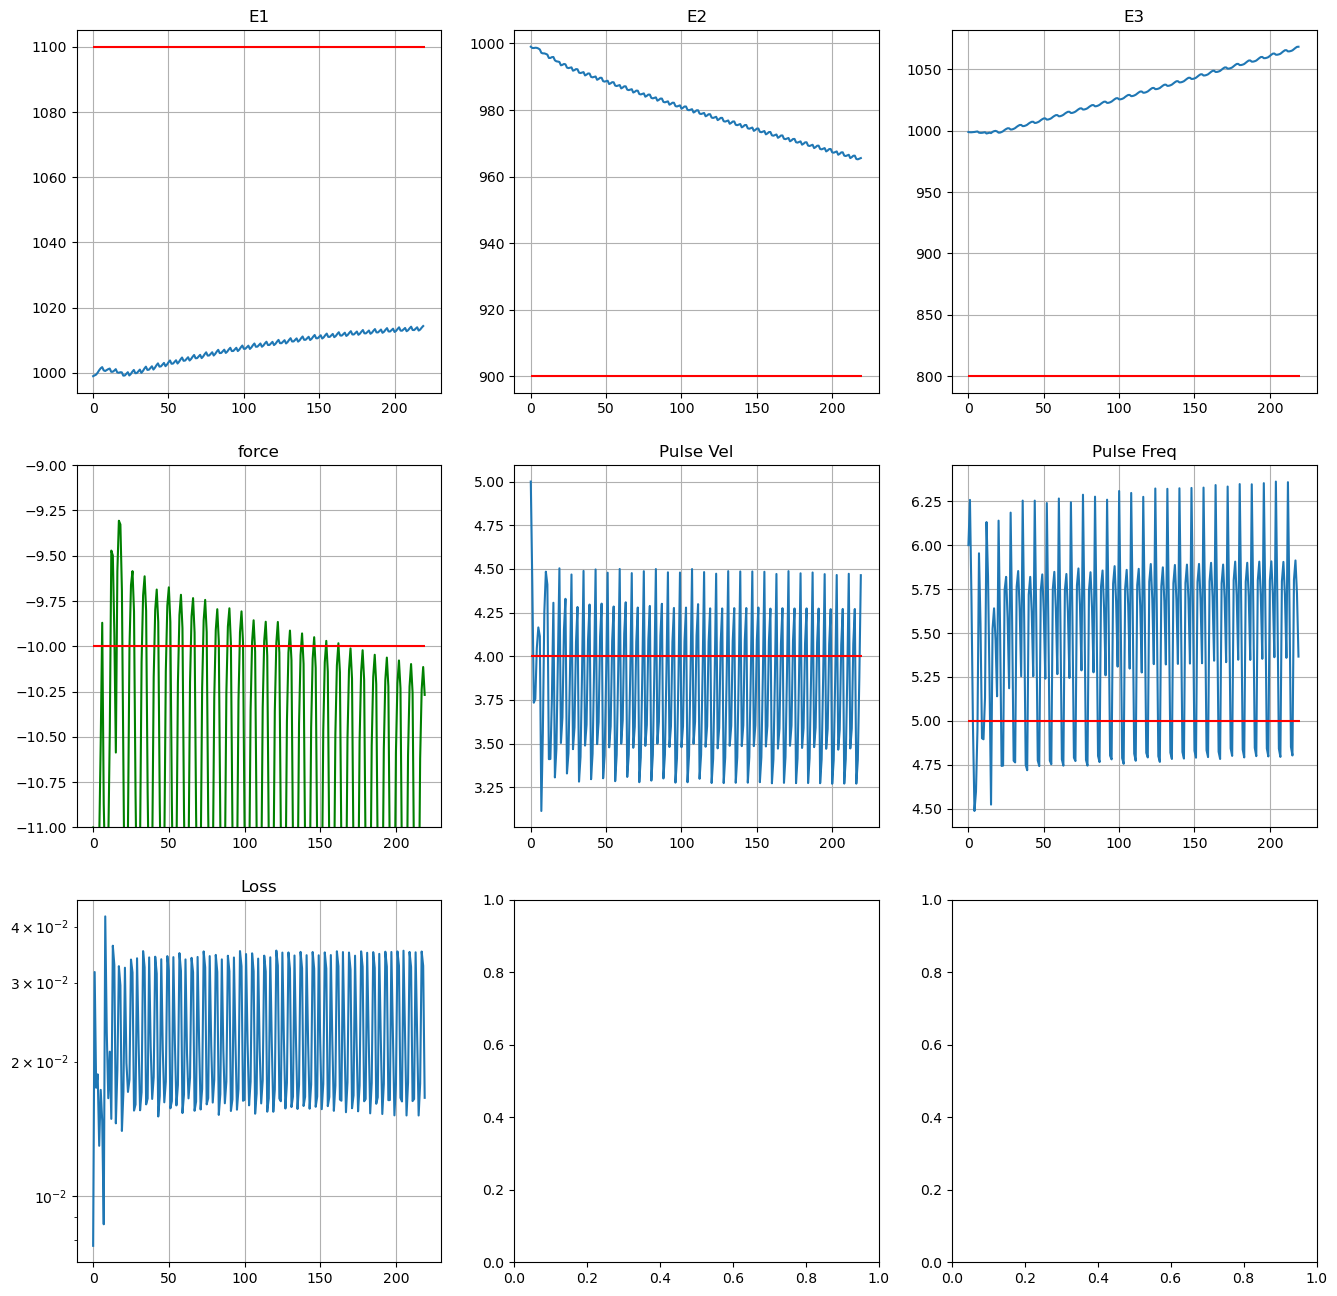

In [23]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
E_true = [1100, 900, 800]
true_f = -10
velocity = 4
frequency = 5

param_list = jnp.load("params.npy").reshape((-1,6))
loss_list = jnp.load("losses.npy")
n = param_list.shape[0]
fig, ax = plt.subplots(3, 3, figsize=(16, 16))
ax = ax.flat
ax[0].plot(param_list[:,0], markersize=2)
ax[0].hlines(E_true[0], 0, n, color='r')
ax[0].grid()
ax[0].set_title('E1')
ax[1].plot(param_list[:,1], markersize=2)
ax[1].hlines(E_true[1], 0, n, color='r')
ax[1].grid()
ax[1].set_title('E2')
ax[2].plot(param_list[:,2], markersize=2)
ax[2].hlines(E_true[2], 0, n, color='r')
ax[2].grid()
ax[2].set_title('E3')
ax[3].plot(range(n), param_list[:,5], markersize=2, color='green')
ax[3].autoscale(enable=False, axis='y')
ax[3].set_ylim(true_f*1.1, true_f*0.9)
ax[3].hlines(true_f, 0, n-1, color='r')
ax[3].grid()
ax[3].set_title('force')
ax[4].plot(param_list[:,3], markersize=2)
ax[4].hlines(4, 0, n, color='r')
ax[4].grid()
ax[4].set_title('Pulse Vel')
ax[5].plot(param_list[:,4], markersize=2)
ax[5].hlines(5, 0, n, color='r')
ax[5].grid()
ax[5].set_title('Pulse Freq')
ax[6].plot(loss_list)
ax[6].grid()
ax[6].set_title('Loss')
ax[6].set_yscale('log')
plt.savefig('learning_curve')

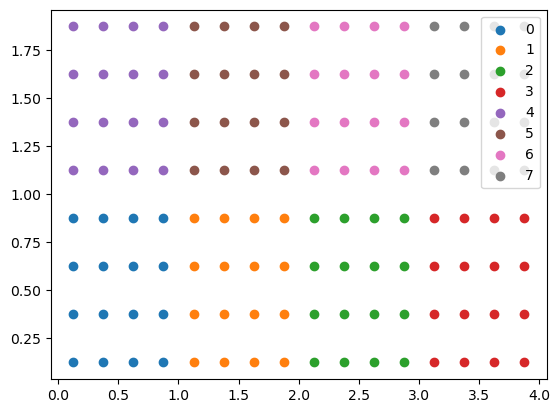

In [ ]:
with open("particles.json", "r") as f:
    ploc = jnp.asarray(json.load(f))

for i in range(8):
    plt.scatter(ploc[16*i:16*(i+1),0,0], ploc[16*i:16*(i+1),0,1], label=i)

plt.legend()
plt.show()